In [10]:
import os
import sys

In [13]:
ai2md_path = r"C:\Users\23174\Desktop\GitHub Project\GitHubProjectBigData\GNN-Molecular-Project\GNN-LF-AND-ColfNet"
sys.path.append(str(ai2md_path))

In [14]:
from  dl_gnn.models.visnet.models.visnet_block import *

c:\Users\23174\anaconda3\envs\pytorch\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [17]:

# 初始化ViS_MP实例
vis_mp_layer = ViS_MP(
    num_heads=8,
    hidden_channels=256,
    activation="silu",
    attn_activation="silu",
    cutoff=5.0,
    vecnorm_type="max_min",
    trainable_vecnorm=False,
    last_layer=False
)


In [37]:
import torch
from torch_geometric.data import Data

# 设定随机种子以确保结果可复现
torch.manual_seed(0)

hidden_dim = 256         # 隐藏层维度
edge_number = 3541       # 边的数量
batch_size = 11          # 批次大小
atomic_number = 21       # 每个批次中原子的数量

batch_atomic_number = atomic_number * batch_size  # 总原子数量

# 生成节点特征矩阵 x,形状为 (batch_atomic_number, hidden_dim) =>  已有
x = torch.randn(batch_atomic_number, hidden_dim)

# 生成向量特征矩阵 vec,形状为 (batch_atomic_number, 8, hidden_dim)  => 可以通过生成得到
vec = torch.randn(batch_atomic_number, 8, hidden_dim)
 
# 生成边索引 edge_index,形状为 (2, edge_number)     => 可以通过生成得到
edge_index = torch.randint(0, batch_atomic_number, (2, edge_number))

# 生成边权重 edge_weight,形状为 (edge_number,) => 可以通过生成得到
edge_weight = torch.rand(edge_number)

# 生成边属性 edge_attr,形状为 (edge_number, hidden_dim) => 可以通过生成得到
edge_attr = torch.randn(edge_number, hidden_dim)

# 生成边向量 edge_vec,形状为 (edge_number, 8) => 可以通过生成得到
edge_vec = torch.randn(edge_number, 8)

# 运行forward函数
# dx, dvec, df_ij
out = vis_mp_layer(x, vec, edge_index, r_ij=edge_weight, f_ij=edge_attr, d_ij=edge_vec)
print("输出形状:", [o.shape for o in out])

输出形状: [torch.Size([231, 256]), torch.Size([231, 8, 256]), torch.Size([3541, 256])]


In [7]:
import torch
import math
from torch import nn

class Sphere(nn.Module):

    def __init__(self, l=2):
        super(Sphere, self).__init__()
        self.l = l

    def forward(self, edge_vec):
        edge_sh = self._spherical_harmonics(
            self.l, edge_vec[..., 0], edge_vec[..., 1], edge_vec[..., 2]
        )
        return edge_sh

    @staticmethod
    def _spherical_harmonics(
        lmax: int, x: torch.Tensor, y: torch.Tensor, z: torch.Tensor
    ) -> torch.Tensor:

        sh_1_0, sh_1_1, sh_1_2 = x, y, z

        if lmax == 1:
            return torch.stack([sh_1_0, sh_1_1, sh_1_2], dim=-1)

        sh_2_0 = math.sqrt(3.0) * x * z
        sh_2_1 = math.sqrt(3.0) * x * y
        y2 = y.pow(2)
        x2z2 = x.pow(2) + z.pow(2)
        sh_2_2 = y2 - 0.5 * x2z2
        sh_2_3 = math.sqrt(3.0) * y * z
        sh_2_4 = math.sqrt(3.0) / 2.0 * (z.pow(2) - x.pow(2))

        if lmax == 2:
            return torch.stack(
                [sh_1_0, sh_1_1, sh_1_2, sh_2_0, sh_2_1, sh_2_2, sh_2_3, sh_2_4], dim=-1
            )
batch_size = 17
atomic_number = 21
hid_dim = 256

# Creating mock data for the tensors
mask = torch.rand(batch_size, atomic_number, atomic_number, hid_dim)
s = torch.rand(batch_size, atomic_number, hid_dim)
atomic_adjacency_matrix = torch.rand(batch_size, atomic_number, atomic_number)
pos = torch.rand(batch_size, atomic_number, 3)

lmax = 2
x = s.view(s.size(0) * s.size(1), s.size(2))  # node features
vec = torch.zeros(
    x.size(0), ((lmax + 1) ** 2) - 1, x.size(1), device=x.device
)

batch_idx, rows_idx, cols_idx = torch.nonzero(atomic_adjacency_matrix, as_tuple=True)

rows = rows_idx + batch_idx * atomic_number
cols = cols_idx + batch_idx * atomic_number
edge_index = torch.stack([rows, cols], dim=0)
edge_weights = atomic_adjacency_matrix[batch_idx, rows_idx, cols_idx]
edge_attr = mask[batch_idx, rows_idx, cols_idx, :]
edge_vec = pos[batch_idx, rows_idx, :] - pos[batch_idx, cols_idx, :]
sphere = Sphere(l=lmax)
edge_vec = sphere(edge_vec)
res =  {
    "mask_shape": mask.shape,
    "s_shape": s.shape,
    "atomic_adjacency_matrix_shape": atomic_adjacency_matrix.shape,
    "pos_shape": pos.shape,
    "vec_shape": vec.shape,
    "edge_index_shape": edge_index.shape,
    "edge_weights_shape": edge_weights.shape,
    "edge_attr_shape": edge_attr.shape,
    "edge_vec_shape": edge_vec.shape
}

res

{'mask_shape': torch.Size([17, 21, 21, 256]),
 's_shape': torch.Size([17, 21, 256]),
 'atomic_adjacency_matrix_shape': torch.Size([17, 21, 21]),
 'pos_shape': torch.Size([17, 21, 3]),
 'vec_shape': torch.Size([357, 8, 256]),
 'edge_index_shape': torch.Size([2, 7497]),
 'edge_weights_shape': torch.Size([7497]),
 'edge_attr_shape': torch.Size([7497, 256]),
 'edge_vec_shape': torch.Size([7497, 8])}

In [3]:
x.shape

torch.Size([357, 256])

# 测试一下写一个消息传递的网络

In [129]:
from typing import Optional, Tuple
import torch
import torch.nn as nn
from torch.nn import SiLU
from torch import Tensor
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_scatter import scatter


class GNNLFAttentionMessage(nn.Module):
    def __init__(
        self,
        num_heads,
        hidden_channels,
        # activation,
        # attn_activation,
        # cutoff,
        last_layer=False,
    ):
        super(GNNLFAttentionMessage, self).__init__()
        assert hidden_channels % num_heads == 0, (
            f"The number of hidden channels ({hidden_channels}) "
            f"must be evenly divisible by the number of "
            f"attention heads ({num_heads})"
        )

        self.num_heads = num_heads
        self.hidden_channels = hidden_channels
        self.head_dim = hidden_channels // num_heads
        self.last_layer = last_layer
        self.layernorm = nn.LayerNorm(hidden_channels)
        # self.vec_layernorm = VecLayerNorm(
        #     hidden_channels, trainable=trainable_vecnorm, norm_type=vecnorm_type
        # )
        self.act = SiLU()
        self.attn_activation = SiLU()

        # self.cutoff = CosineCutoff(cutoff)

        self.vec_proj = nn.Linear(hidden_channels, hidden_channels * 3, bias=False)

        self.q_proj = nn.Linear(hidden_channels, hidden_channels)
        self.k_proj = nn.Linear(hidden_channels, hidden_channels)
        self.v_proj = nn.Linear(hidden_channels, hidden_channels)
        self.dk_proj = nn.Linear(hidden_channels, hidden_channels)
        self.dv_proj = nn.Linear(hidden_channels, hidden_channels)

        self.s_proj = nn.Linear(hidden_channels, hidden_channels * 2)
        if not self.last_layer:
            self.f_proj = nn.Linear(hidden_channels, hidden_channels)
            self.w_src_proj = nn.Linear(hidden_channels, hidden_channels, bias=False)
            self.w_trg_proj = nn.Linear(hidden_channels, hidden_channels, bias=False)

        self.o_proj = nn.Linear(hidden_channels, hidden_channels * 3)

        self.reset_parameters()


    @staticmethod
    def vector_rejection(vec, d_ij):
        vec_proj = (vec * d_ij.unsqueeze(2)).sum(dim=1, keepdim=True)
        return vec - vec_proj * d_ij.unsqueeze(2)

    def reset_parameters(self):
        self.layernorm.reset_parameters()
        # self.vec_layernorm.reset_parameters()
        nn.init.xavier_uniform_(self.q_proj.weight)
        self.q_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.k_proj.weight)
        self.k_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.v_proj.weight)
        self.v_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.s_proj.weight)
        self.s_proj.bias.data.fill_(0)

        if not self.last_layer:
            nn.init.xavier_uniform_(self.f_proj.weight)
            self.f_proj.bias.data.fill_(0)
            nn.init.xavier_uniform_(self.w_src_proj.weight)
            nn.init.xavier_uniform_(self.w_trg_proj.weight)

        nn.init.xavier_uniform_(self.vec_proj.weight)
        nn.init.xavier_uniform_(self.dk_proj.weight)
        self.dk_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.dv_proj.weight)
        self.dv_proj.bias.data.fill_(0)

        

    def forward(self, s, ef_mask):
        """
        :param s: batch_size x atomic_number x hid_dim    => Node Features
        :param ef_mask: batch_size x atomic_number x atomic_number x hid_dim  => Edge Features
        :return:
        """
        batch_size, atomic_number, hid_dim = s.shape
        x = s
        
        vec = ef_mask
        x = self.layernorm(x)
        vec = self.layernorm(vec)  # 这里后面调整一下, 只是调整一下hidden_channels, 只是把最后一个维度的hid_dim 变成hidden_channels * num_heads
        q = self.q_proj(x).view(batch_size, atomic_number, self.num_heads, self.head_dim)
        k = self.k_proj(x).view(batch_size, atomic_number, self.num_heads, self.head_dim)
        v = self.v_proj(x).view(batch_size, atomic_number, self.num_heads, self.head_dim)
        vec1, vec2, vec3 = torch.split(self.vec_proj(vec), self.hidden_channels, dim=-1)
        vec_dot = (vec1 * vec2).sum(dim=1)
        x, vec_out = self.propagate(
            q,
            k,
            v,
            vec,
            size=None,
        )

        # x shpae: torch.Size([6, 21, 256])

        o1, o2, o3 = torch.split(self.o_proj(x), self.hidden_channels, dim=-1)
        dx = vec_dot * o2 + o3
        dvec = vec3 * o1.unsqueeze(1) + vec_out
        # if not self.last_layer:
        #     # edge_updater_type: (vec: Tensor, d_ij: Tensor, f_ij: Tensor)
        #     df_ij = self.edge_updater(edge_index, vec=vec, d_ij=d_ij, f_ij=f_ij)
        #     return dx, dvec, df_ij
        # else:
        return dx, dvec, None

    def message(self, q_i, k_j, v_j, vec_j):
        attn = (q_i * k_j).sum(dim=-1)
        attn = self.attn_activation(attn)
        # 完全理解不了这里是怎么算的，他就是这样的喽， 不管了。

        v_j = (v_j * attn.unsqueeze(-1))  # batch_size x atomic_number x hid_dim
        # v_j shape torch.Size([6, 21, 8, 32])
        v_j = v_j.view(v_j.size(0), v_j.size(1), -1)

        s1, s2 = torch.split(self.act(self.s_proj(v_j)), self.hidden_channels, dim=-1)
        vec_j = vec_j * s1.unsqueeze(1) + s2.unsqueeze(1)

        return v_j, vec_j

    # def edge_update(self, vec_i, vec_j, d_ij, f_ij):
    #     w1 = self.vector_rejection(self.w_trg_proj(vec_i), d_ij)
    #     w2 = self.vector_rejection(self.w_src_proj(vec_j), -d_ij)
    #     w_dot = (w1 * w2).sum(dim=1)
    #     df_ij = self.act(self.f_proj(f_ij)) * w_dot
    #     return df_ij

    def aggregate(
        self,
        features: Tuple[torch.Tensor, torch.Tensor],
        index: torch.Tensor,
        ptr: Optional[torch.Tensor],
        dim_size: Optional[int],
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        raise NotImplementedError   
        agger_method = "mean"
        x, vec = features
        node_dim = 0
        x = scatter(x, index, dim=node_dim, dim_size=dim_size, reduce=agger_method)
        vec = scatter(vec, index, dim=node_dim, dim_size=dim_size, reduce=agger_method)  # TODO: 修改聚合里面的求和为mean防止数值梯度爆炸

        return x, vec
    
    def propagate(self, q, k, v, vec, size):
        v_j, vec_j = self.message(q, k, v, vec)
        # x, vec_out = self.aggregate((v_j, vec_j), size[1], size[0], size[1])
        return  v_j, vec_j 

    def update(
        self, inputs: Tuple[torch.Tensor, torch.Tensor]
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        raise NotImplementedError
        return inputs

In [130]:

batch_size = 6
atomic_number = 21
hid_dim = 256
num_heads = 8
message_net = GNNLFAttentionMessage(num_heads=num_heads, hidden_channels=hid_dim)

In [131]:

s = torch.rand(batch_size, atomic_number, hid_dim)
ef_mask = torch.rand(batch_size, atomic_number, atomic_number, hid_dim)

In [132]:
dx, dvec, _ = message_net(s, ef_mask)

message 
v_j shape torch.Size([6, 21, 256])
vec_j shape torch.Size([6, 21, 21, 256])


# Plot

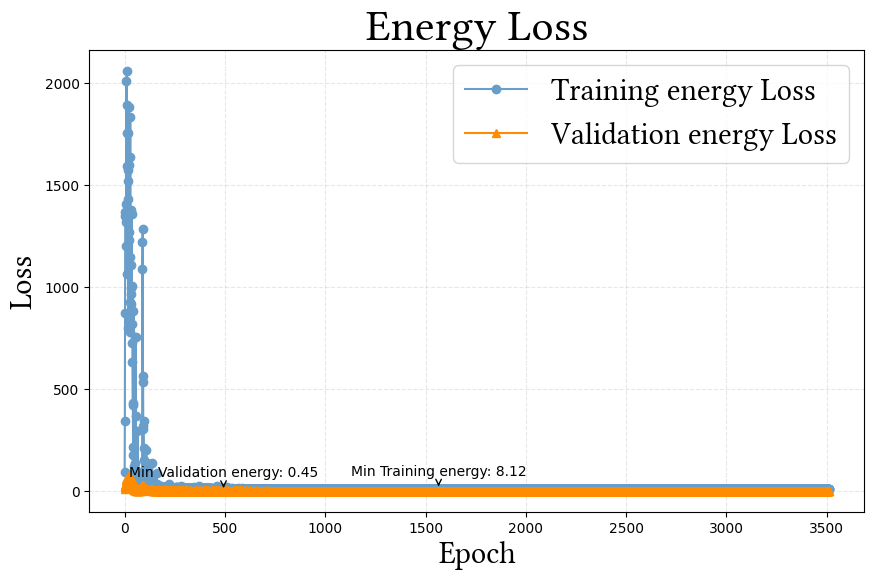

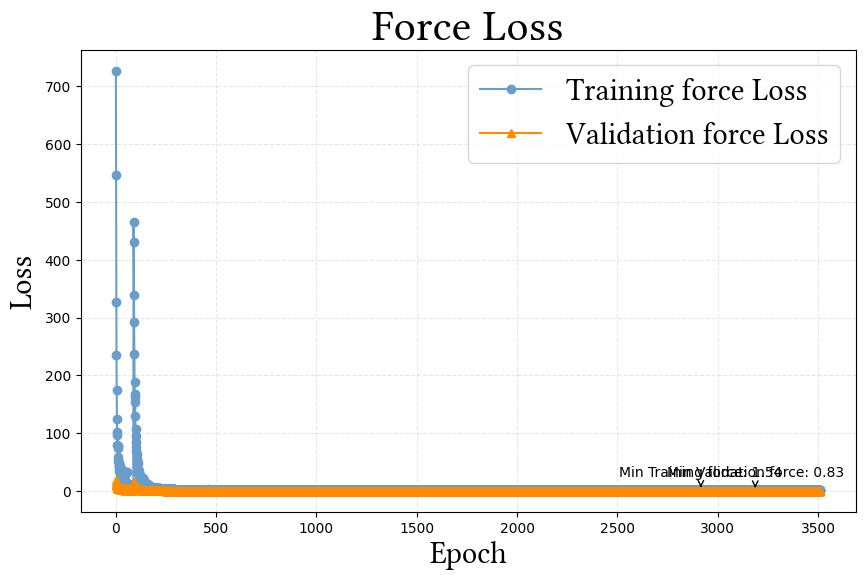

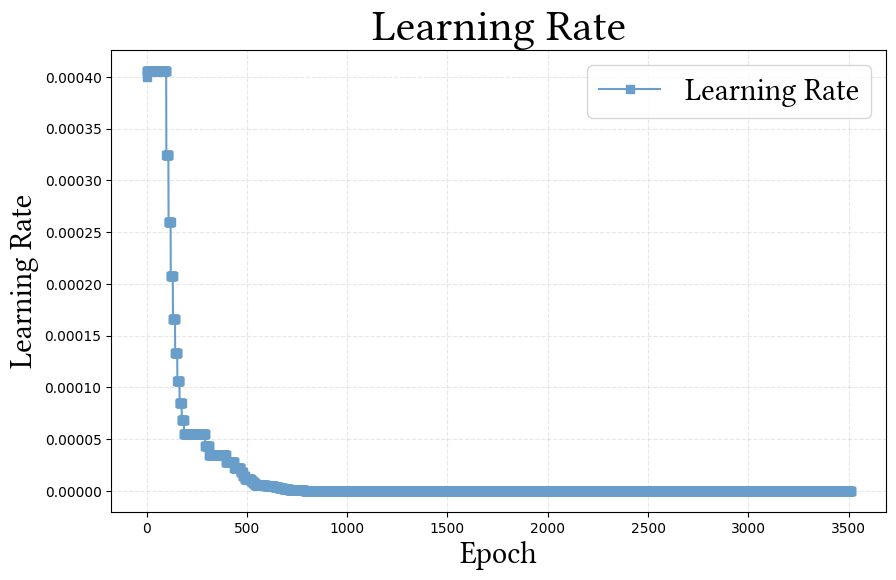

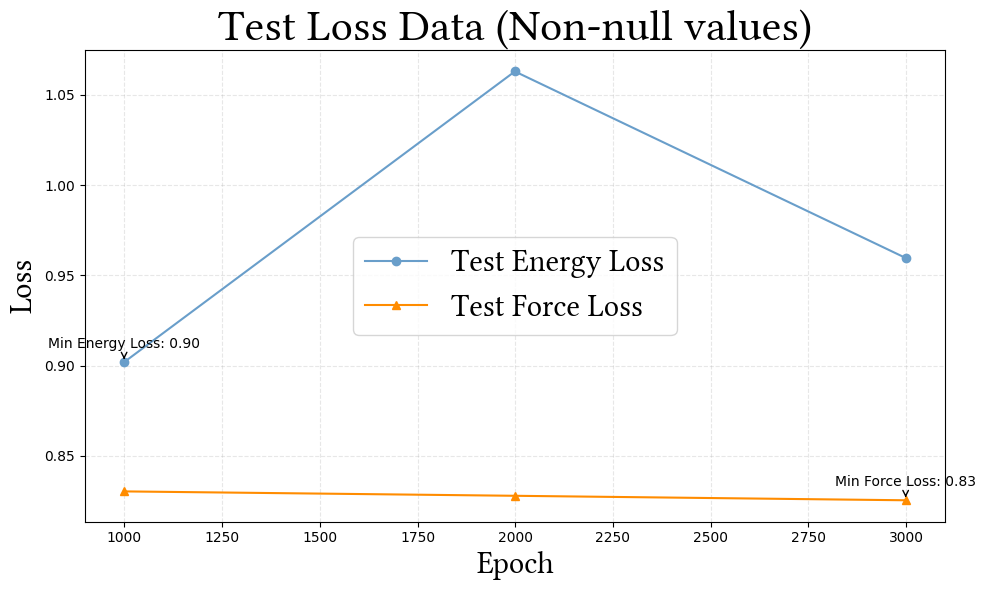

In [147]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
import pandas as pd
 # font_path
# fname must be the absolute path !!!
font_path = r"C:\Users\23174\Downloads\LinLibertine_R.ttf"
times_font_path = r"C:\Users\23174\Downloads\times.ttf"
myfont1 = FontProperties(fname=times_font_path, size=22)  
myfont2 = FontProperties(fname=font_path, size=32)
myfont3 = FontProperties(fname=font_path, size=22)
myfont4 = FontProperties(fname=font_path, size=26)
myfont5 = FontProperties(fname=font_path, size=24)
myfont6 = FontProperties(fname=font_path, size=20)
myfont7 = FontProperties(size=14)
myfont8 = FontProperties(size=12)

colors = ['#699ECA', '#FF8C00', '#F898CB', '#4DAF4A', 
          '#D65190', '#731A73', '#FFCB5B', '#E87B1E', 
          '#0076B9', '#3D505A', '#0098B2']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

csv_path = r"C:\Users\23174\Desktop\GitHub Project\GitHubProjectBigData\GNN-Molecular-Project\GNN-LF-AND-ColfNet\dl_gnn\tests\05-28-22-aspirin-0-Kan-GNNLF.csv"
data = pd.read_csv(csv_path)

def annotate_min_corrected(x, y, ax, label):
    if y.notna().any():
        min_value = np.min(y.dropna())
        min_index = y.idxmin()
        ax.annotate(f'Min {label}: {min_value:.2f}', xy=(x.loc[min_index], min_value), 
                    xytext=(0,10), textcoords="offset points",
                    arrowprops=dict(facecolor='black', arrowstyle='->'), ha='center')

def plot_loss(data, loss_type, ax, title):
    ax.set_prop_cycle(color=colors)

    train_loss = data[f'training {loss_type} loss']
    val_loss = data[f'validation {loss_type} loss']
    ax.plot(data['epoch'], train_loss, label=f'Training {loss_type} Loss', linestyle='-', marker='o')
    ax.plot(data['epoch'], val_loss, label=f'Validation {loss_type} Loss', linestyle='-', marker='^')
    annotate_min_corrected(data['epoch'], train_loss, ax, f'Training {loss_type}')
    annotate_min_corrected(data['epoch'], val_loss, ax, f'Validation {loss_type}')
    ax.set_xlabel('Epoch', fontproperties=myfont3)
    ax.set_ylabel('Loss', fontproperties=myfont3)
    ax.set_title(title, fontproperties=myfont2)
    ax.legend(prop=myfont3)
    ax.grid(alpha=0.3, linestyle='--')

# 1. Energy Loss
fig, ax1 = plt.subplots(figsize=(10, 6))
plot_loss(data, 'energy', ax1, 'Energy Loss')

# 2. Force Loss
fig, ax2 = plt.subplots(figsize=(10, 6))  
plot_loss(data, 'force', ax2, 'Force Loss')

# 3. Learning Rate
fig, ax3 = plt.subplots(figsize=(10, 6))
ax3.plot(data['epoch'], data['learning rate'], label='Learning Rate', linestyle='-', marker='s')
ax3.set_xlabel('Epoch', fontproperties=myfont3)
ax3.set_ylabel('Learning Rate', fontproperties=myfont3) 
ax3.set_title('Learning Rate', fontproperties=myfont2)
ax3.legend(prop=myfont3)
ax3.grid(alpha=0.3, linestyle='--')

# 4. Test Loss (Non-null values)
filtered_epochs = data['epoch'][data['test energy loss'].notna()]
fig, ax4 = plt.subplots(figsize=(10, 6))
ax4.plot(filtered_epochs, data['test energy loss'].dropna(), label='Test Energy Loss', marker='o', linestyle='-')
ax4.plot(filtered_epochs, data['test force loss'].dropna(), label='Test Force Loss', marker='^', linestyle='-')
annotate_min_corrected(filtered_epochs, data['test energy loss'].dropna(), ax4, 'Energy Loss')
annotate_min_corrected(filtered_epochs, data['test force loss'].dropna(), ax4, 'Force Loss')
ax4.set_xlabel('Epoch', fontproperties=myfont3)
ax4.set_ylabel('Loss', fontproperties=myfont3)
ax4.set_title('Test Loss Data (Non-null values)', fontproperties=myfont2)
ax4.legend(prop=myfont3)
ax4.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()